In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as la
import polars as pl
import pandas as pd
import datetime as dt
import os
from pathlib import Path
#from dask.distributed import Client, LocalCluster, as_completed
#from dask import delayed
from runpy import run_path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import networkx as nx
#import raphtory as rp
import umap 
import streamlit as st
from sklearn.preprocessing import StandardScaler

#import local2global as l2g # ADDED

import torch
import torch_geometric as tg
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import LargestConnectedComponents
from torch_geometric.utils import to_networkx, from_networkx, one_hot
from torch_geometric.nn import Node2Vec, GCNConv, VGAE
import torch.nn.functional as F

In [3]:
from l2gv2.datasets import DataLoader
from l2gv2.patch.patch import Patch

In [4]:
PATH = 'l2gv2/datasets/data/nas/'

# <font color="grey">New Autonomous Systems dataset </font>

The purpose of this notebook is to walk through the graph embedding and alignment process in a self-contained way. The full existing Local2Global package is available [here](https://github.com/LJeub/Local2Global_embedding) and the expectation is to pick parts from it as a starting point. It is also available in on this repository in the Local2Global_embedding folder for reference.

### <font color="grey">  Table of Contents</font>

1. #### <a href='#chapter1'>Data</a>
2. #### <a href='#chapter2'>Embedding</a>
3. #### <a href='#chapter3'>Visualisation</a>

###  <a id='chapter1'> <font color="grey">1. Data </font></a>

The data can be accessed via the dataloader. It is saved in the datasets/data/nas directory in two parquet files. There are many alternative ways of doing this. One option to explore is to have the datasets available as in [torch_geometric datasets](https://pytorch-geometric.readthedocs.io/en/2.6.0/modules/datasets.html).

In [5]:
dl = DataLoader(dset='nas')

The data is stored in one dataframe for the nodes (including all the features) and one for the edges (including edge weights).

In [6]:
# Get the nodes
node_df = dl.get_nodes()
node_df.head()

shape: (5, 5)
┌─────────────────────┬──────────┬──────────┬─────────┬────────────────┐
│ timestamp           ┆ nodes    ┆ nodetype ┆ country ┆ asname         │
│ ---                 ┆ ---      ┆ ---      ┆ ---     ┆ ---            │
│ datetime[μs]        ┆ str      ┆ str      ┆ str     ┆ str            │
╞═════════════════════╪══════════╪══════════╪═════════╪════════════════╡
│ 2024-09-14 00:00:00 ┆ AS7029   ┆ asn      ┆ US      ┆ WINDSTREAM     │
│ 2024-09-14 00:00:00 ┆ AS32984  ┆ asn      ┆ US      ┆ RUELALA-INC    │
│ 2024-09-14 00:00:00 ┆ AS136106 ┆ asn      ┆ ID      ┆ FIBERSTAR-AS-I │
│ 2024-09-14 00:00:00 ┆ AS58495  ┆ asn      ┆ ID      ┆ HSPNET-AS-I    │
│ 2024-09-14 00:00:00 ┆ AS3491   ┆ asn      ┆ US      ┆ BTN-ASN        │
└─────────────────────┴──────────┴──────────┴─────────┴────────────────┘

In [7]:
edge_df = dl.get_edges()
edge_df.head()

shape: (5, 4)
┌─────────────────────┬────────┬─────────┬────────┐
│ timestamp           ┆ source ┆ dest    ┆ weight │
│ ---                 ┆ ---    ┆ ---     ┆ ---    │
│ datetime[μs]        ┆ str    ┆ str     ┆ i64    │
╞═════════════════════╪════════╪═════════╪════════╡
│ 2024-09-14 00:00:00 ┆ AS7029 ┆ AS32984 ┆ 1      │
│ 2024-09-14 00:00:00 ┆ AS7029 ┆ AS19692 ┆ 1      │
│ 2024-09-14 00:00:00 ┆ AS7029 ┆ AS55037 ┆ 1      │
│ 2024-09-14 00:00:00 ┆ AS7029 ┆ AS1820  ┆ 1      │
│ 2024-09-14 00:00:00 ┆ AS7029 ┆ AS16265 ┆ 1      │
└─────────────────────┴────────┴─────────┴────────┘

Ultimately, working with the people at Pometry, we want to use the [Raphtory](https://www.raphtory.com/) graph format.

In [8]:
# Raphtory format
g = dl.get_graph()

The Raphtory formal is still work in progress but one can contribute to their code (based in Rust), contribute to the discussion on their Slack (linked on their page) or directly get in touch with [Lucas Jeub](https://github.com/LJeub) and/or Ben Steer.

In [9]:
print("Stats on the graph structure:")

number_of_nodes = g.count_nodes()
number_of_edges = g.count_edges()
total_interactions = g.count_temporal_edges()

print("Number of nodes (AS nodes):", number_of_nodes)
print("Number of unique edges (src,dst):", number_of_edges)
print("Total interactions (edge updates):", total_interactions)

print("Stats on the graphs time range:")

earliest_datetime = g.earliest_date_time
latest_datetime = g.latest_date_time

print("Earliest datetime:", earliest_datetime)
print("Latest datetime:", latest_datetime)

Stats on the graph structure:
Number of nodes (AS nodes): 85428
Number of unique edges (src,dst): 914346
Total interactions (edge updates): 16717484
Stats on the graphs time range:
Earliest datetime: 2024-09-14 00:00:00+00:00
Latest datetime: 2024-10-13 00:00:00+00:00


In [10]:
print("The node features are: ", g.nodes.properties.keys())

The node features are:  ['asname', 'country', 'nodetype']


The graphs we are dealing are **temporal**, meaning that nodes and edges have timestamps. One can interpret this as having one graph for each point in time, with a possible overlap of nodes and edges.

In [11]:
dates = dl.get_dates()

For this particular dataset, the graph for each day represents a patch. In order to apply graph neural networks to each patch, we need to process these into the Data format used by pytorch-geometric, described [here](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html). In particular, for each patch we need to enumerate the nodes and use these indices to designate the nodes. We need a dictionary that maps the nodes in each patch to their names and we need to encode the node and edge features.

In [12]:
all_node_names = dl.get_node_list()
nodes_index = {x : i for i, x in enumerate(all_node_names)}
all_nodes = list(nodes_index.values())

In [13]:
# Encode nodes present at each date
nodes = {}
node_dict = {}
for d in dates:
    #temp_nodes = dl.get_node_list(ts=d)
    nodes[d] = dl.get_node_list(ts=d)
    node_dict[d] = dict(zip(nodes[d], range(len(nodes[d]))))
all_nodes=dl.get_node_list()

In [14]:
numbering_nodes={x :i for i, x in enumerate(all_nodes)}
list_nodes=list(nodes.values())

list_nodes_renumbered=[]
for l in list_nodes:
    list_nodes_renumbered.append([numbering_nodes[i] for i in l])

In [15]:
# Encode country codes
cc = pl.read_csv(PATH+'country_codes.csv')
countrycode_dict = dict(zip(cc["alpha-2"].to_list(), range(cc.shape[0])))
#cc_one_hot = one_hot(torch.tensor(list(countrycode_dict.values()), dtype=torch.int64))

In [16]:
# Assign country code index to each node. The way this is done is a bit convoluted, as some nodes are assigned to both a country and to 'ZZ'
# in the database, so we need to fix that. This should be done in pre-processing
df = dl.get_nodes().with_columns(
    pl.col("country").replace(old=pl.Series(countrycode_dict.keys()), new=pl.Series(countrycode_dict.values())).cast(pl.Int64).alias('cc')
).select(["nodes", "cc"]).group_by("nodes").agg(pl.col("cc").min().cast(pl.Int64).alias("cc")).sort(["cc","nodes"])
node_cc_dict = dict(zip(df["nodes"].to_list(), df["cc"].to_list()))

In [17]:
# For every day, create a list of node features
features = {}
for d in dates:
    features[d] = one_hot(torch.tensor(dl.get_nodes(ts=d).select(
        pl.col("country").replace(old=pl.Series(countrycode_dict.keys()), new=pl.Series(countrycode_dict.values())).cast(pl.Int64)
    ).to_numpy().flatten()))

In [65]:
df

shape: (85_428, 2)
┌──────────┬─────┐
│ nodes    ┆ cc  │
│ ---      ┆ --- │
│ str      ┆ i64 │
╞══════════╪═════╡
│ AS131284 ┆ 0   │
│ AS132104 ┆ 0   │
│ AS132173 ┆ 0   │
│ AS132222 ┆ 0   │
│ AS132471 ┆ 0   │
│ …        ┆ …   │
│ AS780    ┆ 249 │
│ AS781    ┆ 249 │
│ AS782    ┆ 249 │
│ AS789    ┆ 249 │
│ AS940    ┆ 249 │
└──────────┴─────┘

In [19]:
# Create pytorch-geometric Data object
tg_graphs = {}
for d in tqdm(dates):
    edges = dl.edges.filter(pl.col('timestamp')==d).select(
        pl.col('source').replace(old=pl.Series(node_dict[d].keys()), new=pl.Series(node_dict[d].values())).cast(pl.Int64),
        pl.col('dest').replace(old=pl.Series(node_dict[d].keys()), new=pl.Series(node_dict[d].values())).cast(pl.Int64)
    ).to_numpy()
    edge_index = torch.tensor([tuple(x) for x in edges], dtype=torch.long).t().contiguous()
    tgraph = Data(edge_index=edge_index)
    # Add features - problem is that for the embedding we only want those present at a given time
    tgraph.x = features[d]
    tg_graphs[d] = tgraph

  0%|          | 0/30 [00:00<?, ?it/s]

In [20]:
for i, d in enumerate(dates):
    tg_graphs[d].nodes=torch.tensor(list_nodes_renumbered[i])

In [21]:
# Select one date to test embedding
data = tg_graphs[dates[0]]

###  <a id='chapter2'> <font color="grey">2. Embedding </font></a>

For the embedding, we use the architecture of a Variational Graph Autoencoder. Given a graph $G=(V,E)$ with $|V|=n$ nodes and node features $\vct{x}_i\in \R^d$, $i\in [n]$, denote by $\vct{X}=[\vct{x}_1,\dots,\vct{x}_n]^T\in \R^{n\times d}$ the features matrix and by $A=(a_{ij})\in \{0,1\}^{n\times n}$ the adjacency matrix of the graph. The **encoder** produces latent representations $\vct{z}_i\in \R^k$ for $i\in [n]$, which are sampled from the inference model
\begin{equation*}
  q(\vct{z}_i \ | \ \vct{X},\vct{A}) = \mathcal{N}(\vct{z}_i \ | \ \vct{\mu}_i,\mathrm{diag}(\vct{\sigma}_i)).
\end{equation*}
The means $\mu_i$ and variances $\mathrm{diag}(\vct{\sigma}_i)$ are parametrized using an encoder network, for example, a graph convolutional neural network (GCN). Denoting by $\vct{Z}=[\vct{z}_1,\dots,\vct{z}_n]^T$ the matrix of latent represenations and by $\vct{\mu}$ and $\vct{\sigma}$ the matrices representing the means and variances, we have
\begin{equation*}
  \vct{\mu} = \mathrm{GCN}_{\mu}(\vct{X},\vct{A}), \quad \quad \log \vct{\sigma} = \mathrm{GCN}_{\sigma}(\vct{X},\vct{A}).
\end{equation*}
The **generative model** is a distribution on the adjacency matrix,
\begin{equation*}
  p(\mtx{A}\ | \ \vct{Z}) = \prod_{i,j} p(a_{ij} \ | \ \vct{z}_i,\vct{z}_j).
\end{equation*}
It is convenient to use
\begin{equation*}
  p(a_{ij}=1 \ | \ \vct{z}_i,\vct{z}_j) = \sigma(\vct{z}_i^T\vct{z}_j),
\end{equation*}

where $\sigma$ is the logistic sigmoid. In order to train the model, we optimize the evidence lower bound
\begin{equation*}
  \mathcal{L} = \Expect_{q(\vct{Z}\ | \ \vct{X},\vct{A})}[\log p(\mtx{A}\ | \ \mtx{Z})]-\mathrm{D}_{\mathrm{KL}}(q(\mtx{Z}\ | \ \mtx{X},\mtx{A}) \ \| \ p(\mtx{Z})).
\end{equation*}

In [22]:
class Encoder(torch.nn.Module):
    """
    Implement a Graph Convolutional Network (GCN) as encoder
    """
    def __init__(self, dim, num_node_features, hidden_dim=128, cached=True, bias=True, add_self_loops=True, normalize=True):
        super().__init__()
        self.x_conv = tg.nn.GCNConv(num_node_features, 
                                    hidden_dim, 
                                    cached=cached, 
                                    bias=bias, 
                                    add_self_loops=add_self_loops,
                                    normalize=normalize)
        self.mean_conv = tg.nn.GCNConv(hidden_dim, 
                                       dim, 
                                       cached=cached,
                                       bias=bias, 
                                       add_self_loops=add_self_loops,
                                       normalize=normalize)
        self.var_conv = tg.nn.GCNConv(hidden_dim, 
                                      dim, 
                                      cached=cached, 
                                      bias=bias, add_self_loops=add_self_loops,
                                      normalize=normalize)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index

        x = self.x_conv(x, edge_index)
        x = F.relu(x)

        mu = self.mean_conv(x, edge_index)
        sigma = self.var_conv(x, edge_index)
        return mu, sigma

In [23]:
model = VGAE(encoder=Encoder(64, data.num_node_features))
#model = VGAE(encoder=VGAEconv(2, test_data.num_node_features))

In [24]:
def VGAE_loss(model, data):
    return model.recon_loss(model.encode(data), data.edge_index) + model.kl_loss() / data.num_nodes

In [25]:
def train(data, model, loss_fun, num_epochs=100, verbose=True, lr=0.01, logger=lambda loss: None):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    # schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    for e in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        loss = loss_fun(model, data)
        loss.backward()
        optimizer.step()
        losses.append(float(loss))
        if verbose:
            if not e % 20:
                print(f'epoch {e}: loss={loss.item()}')
        # schedule.step()
    return model, losses

In [26]:
model, losses = train(data, model, VGAE_loss, num_epochs=40)

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=6.7230987548828125
epoch 20: loss=0.9884644150733948


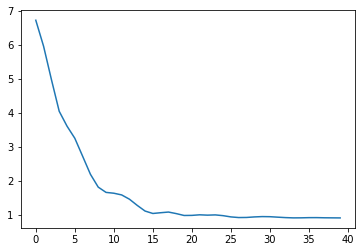

In [27]:
plt.plot(losses)
plt.show()

In [28]:
embedding = model.encode(data).detach().numpy()
embedding.shape

(84592, 64)

In the original L2G code, there is a Patch class handling patches.

###  <a id='chapter3'> <font color="grey">3. Visualisation </font></a>

In [70]:
most_common = ['AU', 'BR', 'CN', 'DE', 'IN', 'ID', 'PL', 'RU', 'GB', 'US']
countries = dl.get_nodes(ts=dates[0])['country'].to_list()
indices = [i for i in range(len(countries)) if countries[i] in most_common]

points = embedding[indices, :]
labels = [most_common.index(countries[i]) for i in indices]

In [31]:
# Use UMAP to visualise the graph embeddings for different days
reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, metric='euclidean')

In [38]:
#points = StandardScaler().fit_transform(points)
points

array([[ 0.17429407,  0.13040492, -0.08490861, ..., -0.08314189,
         0.12081809,  0.10860233],
       [ 0.21692051,  0.09700437, -0.07584915, ..., -0.06256818,
         0.17731337,  0.05445427],
       [ 0.10907319,  0.08493727, -0.00779269, ..., -0.04720683,
         0.21317786,  0.24192981],
       ...,
       [-0.0403138 , -0.10012106,  0.0079902 , ...,  0.04894122,
         0.11048717, -0.16224188],
       [-0.08253901,  0.05924097, -0.04847884, ..., -0.03510494,
         0.08931977,  0.02984705],
       [-0.32192728,  0.12892981, -0.10104018, ..., -0.16417357,
        -0.12956664,  0.04586966]], dtype=float32)

In [33]:
umap_embedding = reducer.fit_transform(points)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in labels],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

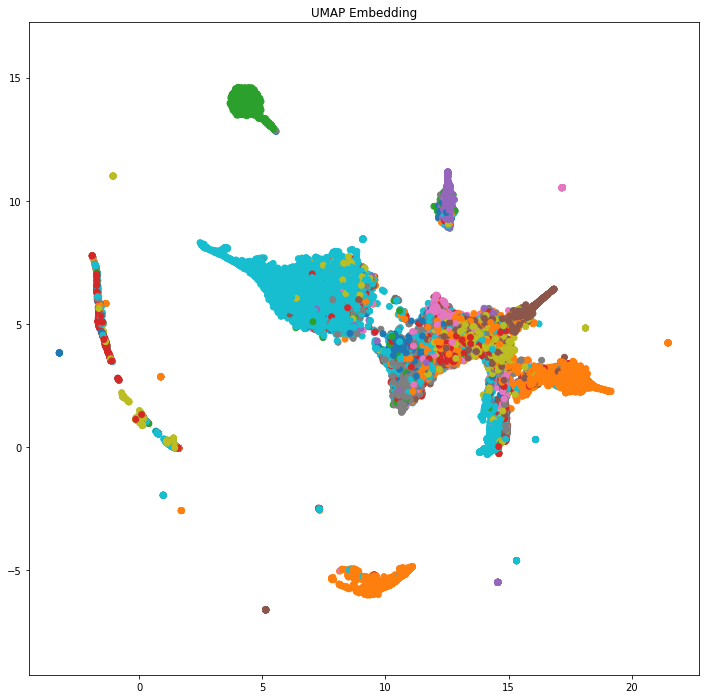

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in labels],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

In [37]:

#patch_list = []
models = []
embeddings = []
patch_emb=[] #ADDED
for d in dates:
    patch = tg_graphs[d]
    model = VGAE(encoder=Encoder(10, patch.num_node_features))
    model, _ = train(patch, model, VGAE_loss, num_epochs=40, lr=0.01)
    patch_emb.append(Patch(patch.nodes, model.encode(patch).detach().numpy())) #ADDED
    #coordinates = model.encode(patch).detach().numpy()
    models.append(model)

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.777951955795288
epoch 20: loss=0.9464203119277954


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.820075750350952
epoch 20: loss=0.9383544921875


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.7980217933654785
epoch 20: loss=0.9458390474319458


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.6852200031280518
epoch 20: loss=0.959855854511261


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.8259525299072266
epoch 20: loss=0.9360523819923401


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.8031504154205322
epoch 20: loss=0.9431180953979492


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.819702386856079
epoch 20: loss=0.933774471282959


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.7331626415252686
epoch 20: loss=0.9417983889579773


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.79899001121521
epoch 20: loss=0.938637912273407


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.7437057495117188
epoch 20: loss=0.9425914883613586


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.7527122497558594
epoch 20: loss=0.9402089715003967


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.7323641777038574
epoch 20: loss=0.9296674132347107


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.69519305229187
epoch 20: loss=0.947329044342041


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.8735311031341553
epoch 20: loss=0.9458163976669312


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.8046810626983643
epoch 20: loss=0.9383399486541748


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.813655138015747
epoch 20: loss=0.9403342008590698


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.7792303562164307
epoch 20: loss=0.9425669312477112


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.695464849472046
epoch 20: loss=0.9552485942840576


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.78537917137146
epoch 20: loss=0.9319592714309692


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.8320024013519287
epoch 20: loss=0.9360535144805908


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.7792303562164307
epoch 20: loss=0.932512640953064


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.744619369506836
epoch 20: loss=0.9325385093688965


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.864452600479126
epoch 20: loss=0.9382628798484802


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.773405075073242
epoch 20: loss=0.9486483335494995


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.7454380989074707
epoch 20: loss=0.9615992903709412


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.814333200454712
epoch 20: loss=0.9410074949264526


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.7192771434783936
epoch 20: loss=0.9519110918045044


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.793175458908081
epoch 20: loss=0.9546276330947876


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.808075189590454
epoch 20: loss=0.9464793801307678


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0: loss=2.8566694259643555
epoch 20: loss=0.9420859217643738


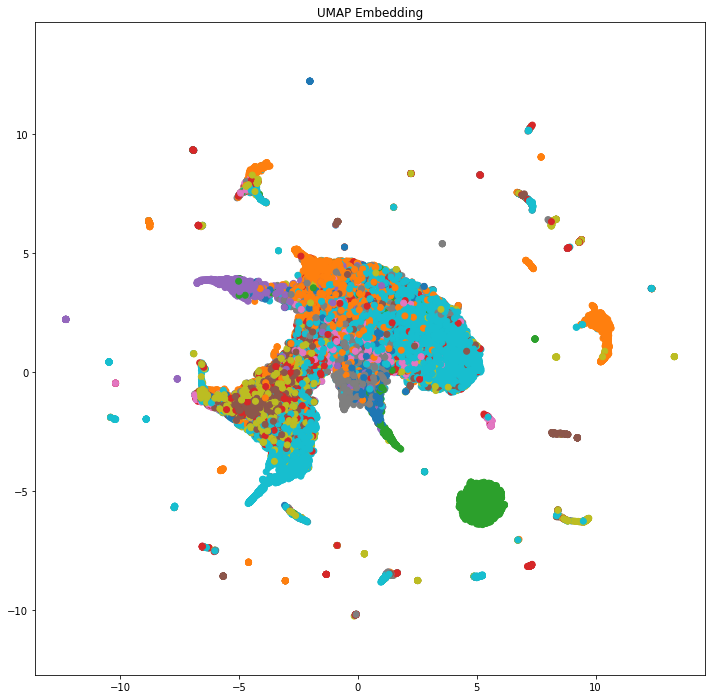

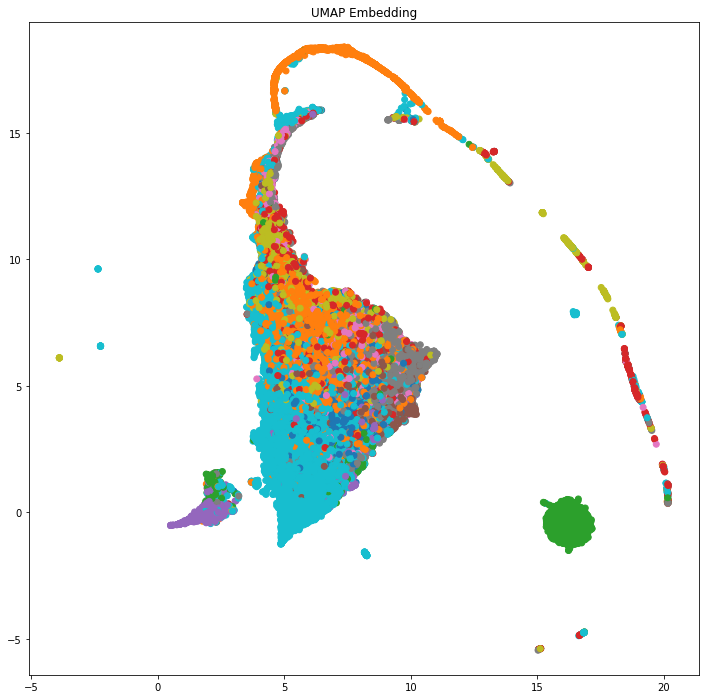

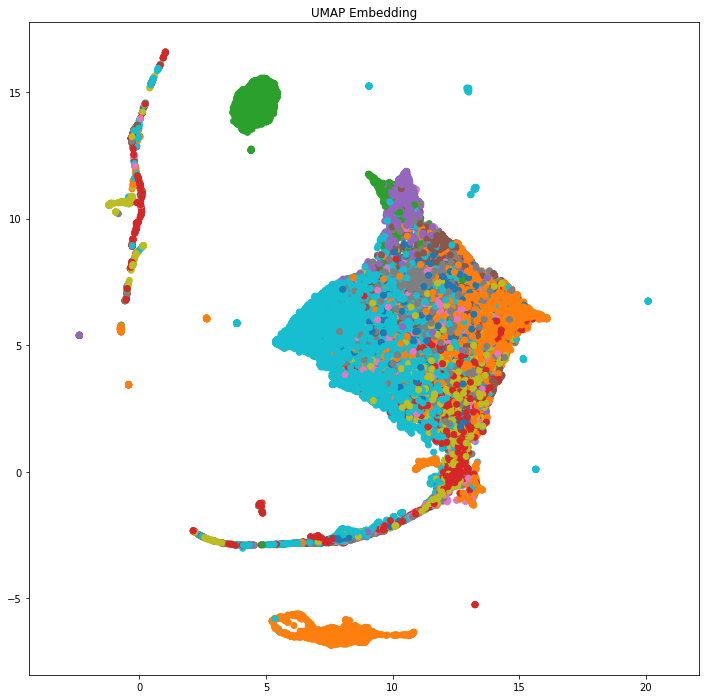

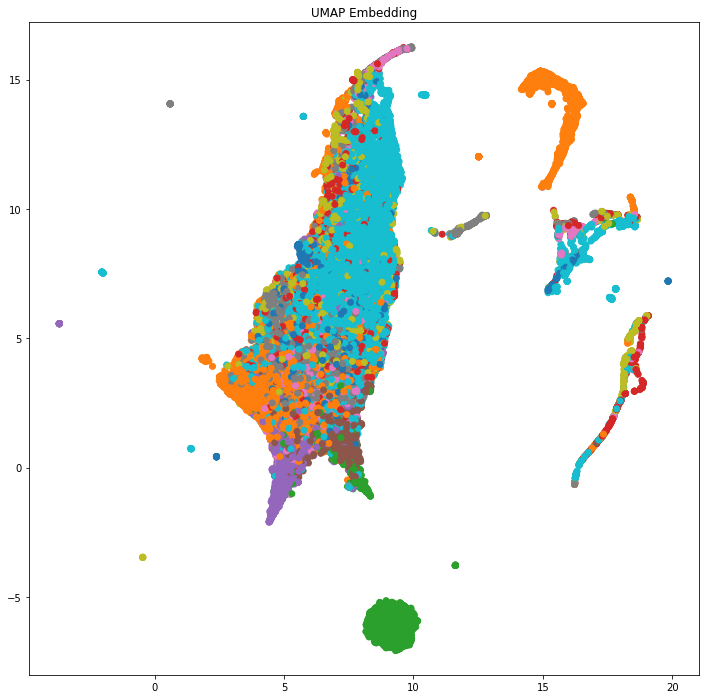

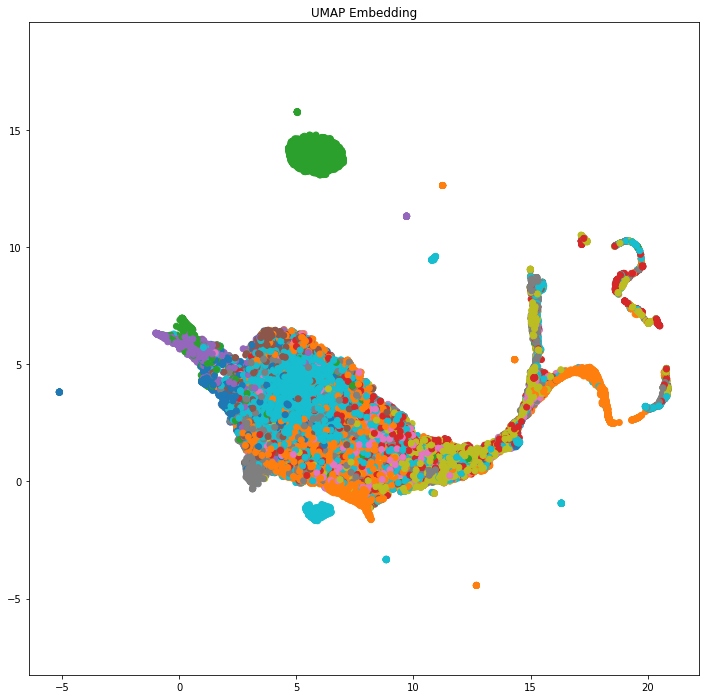

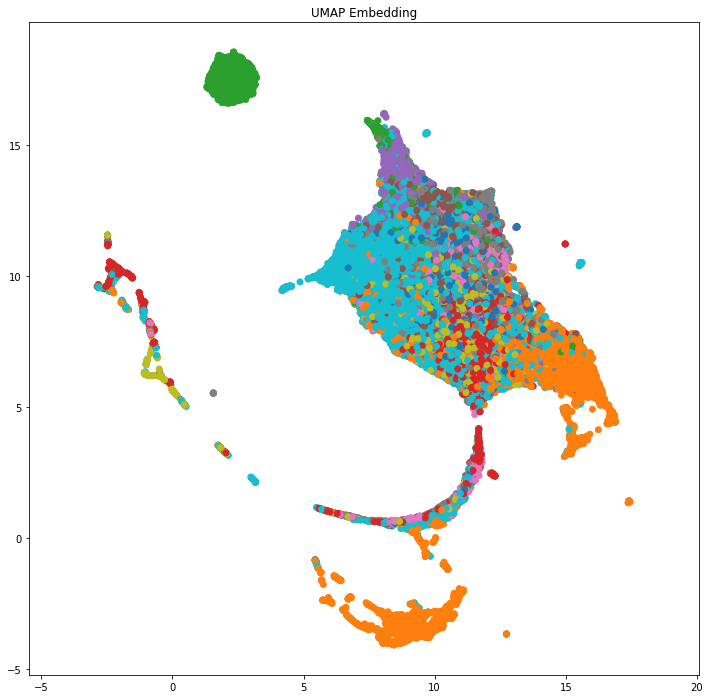

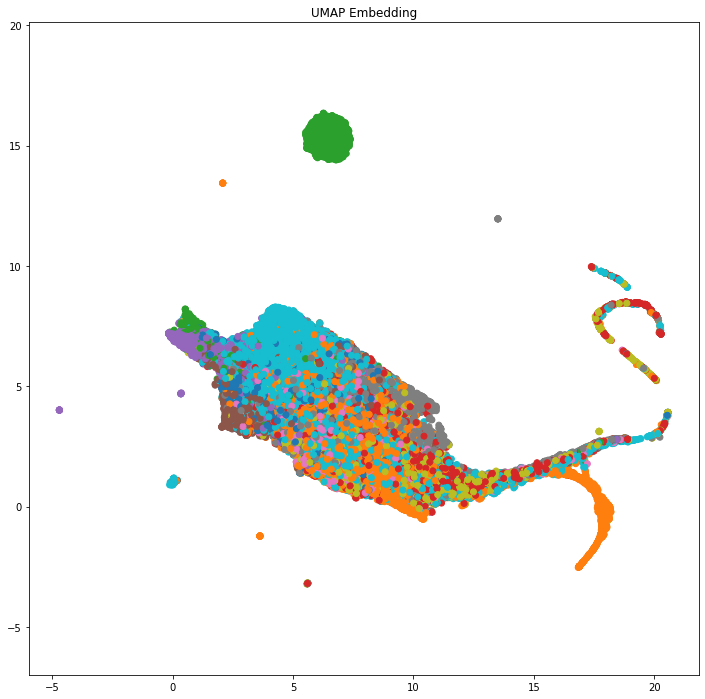

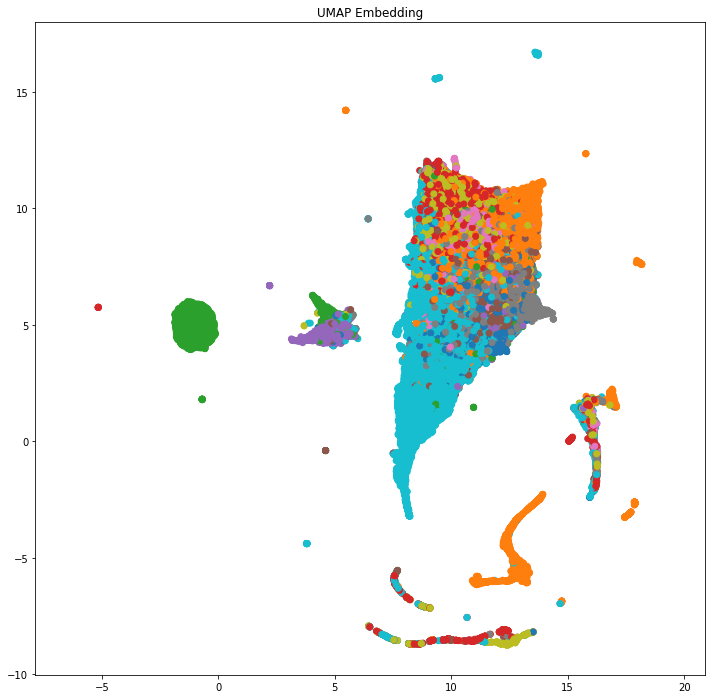

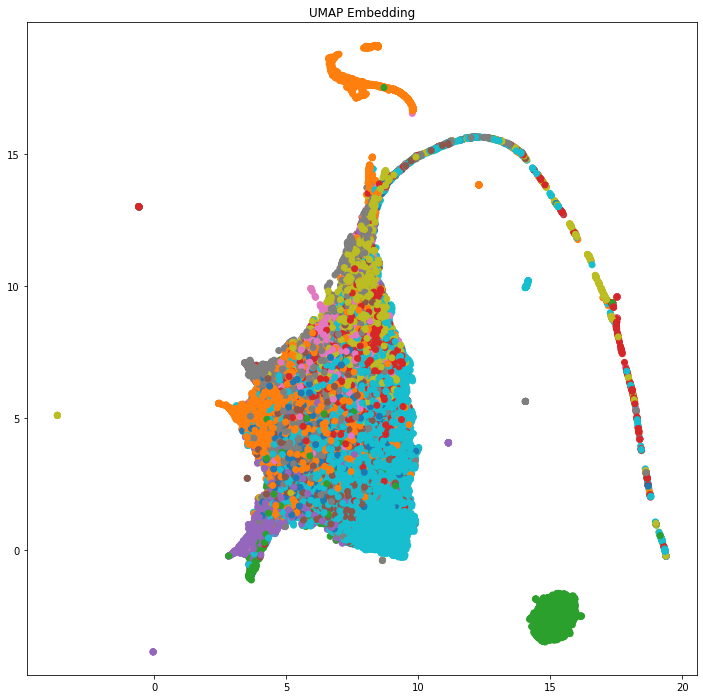

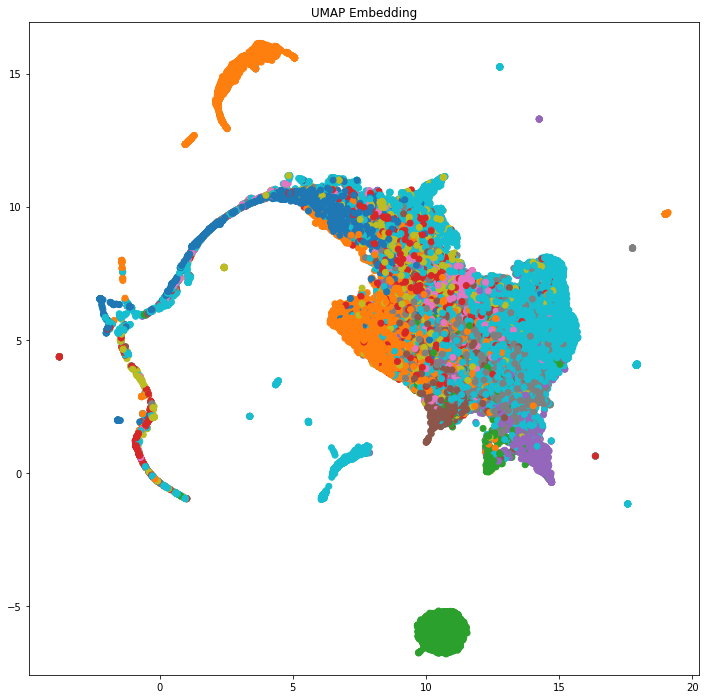

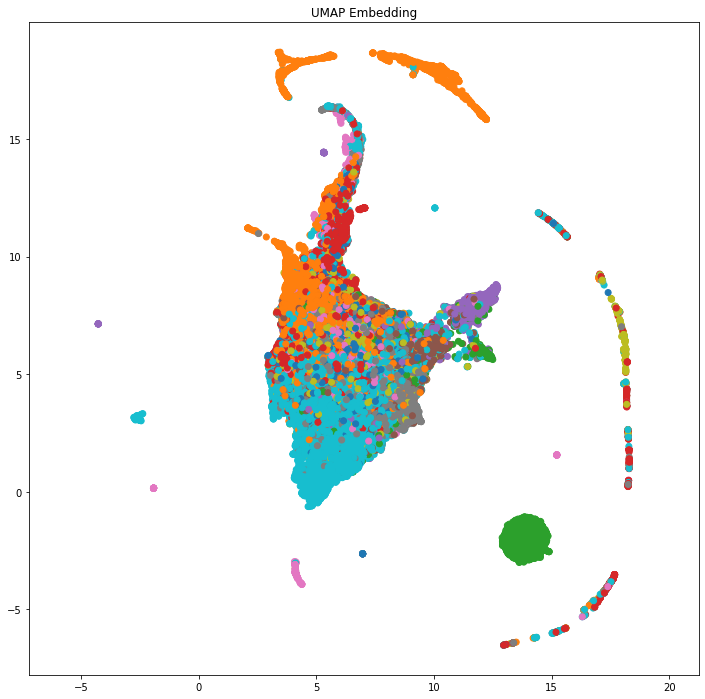

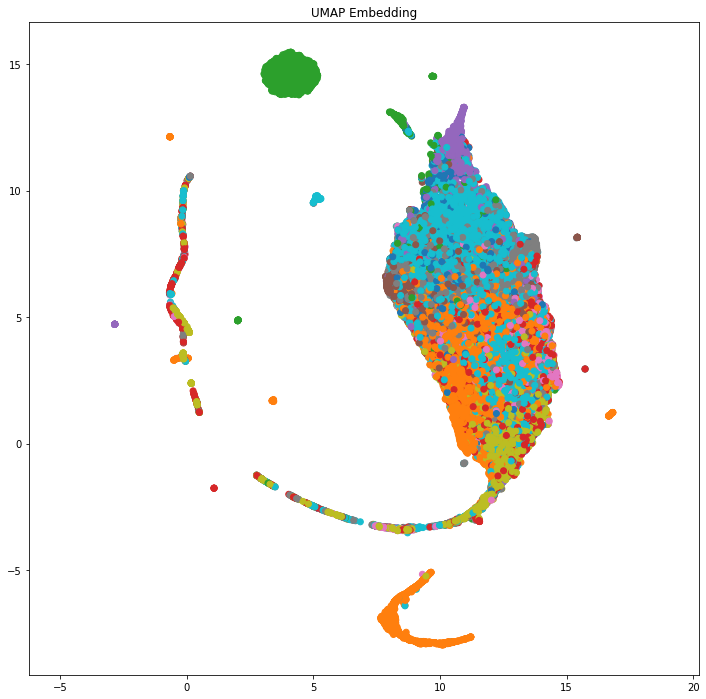

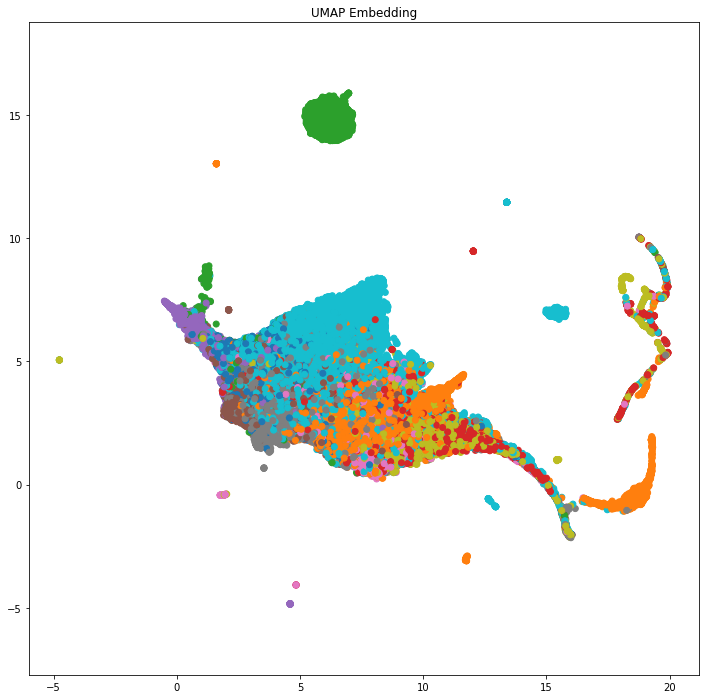

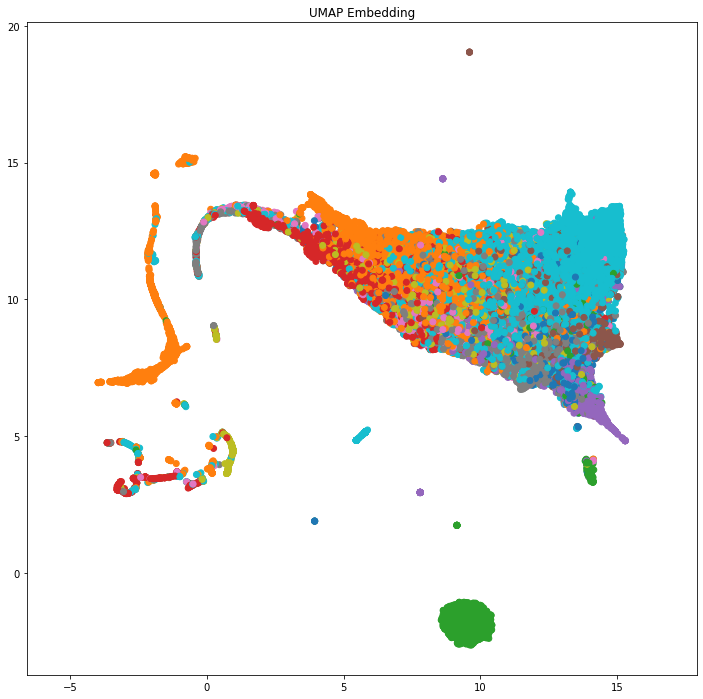

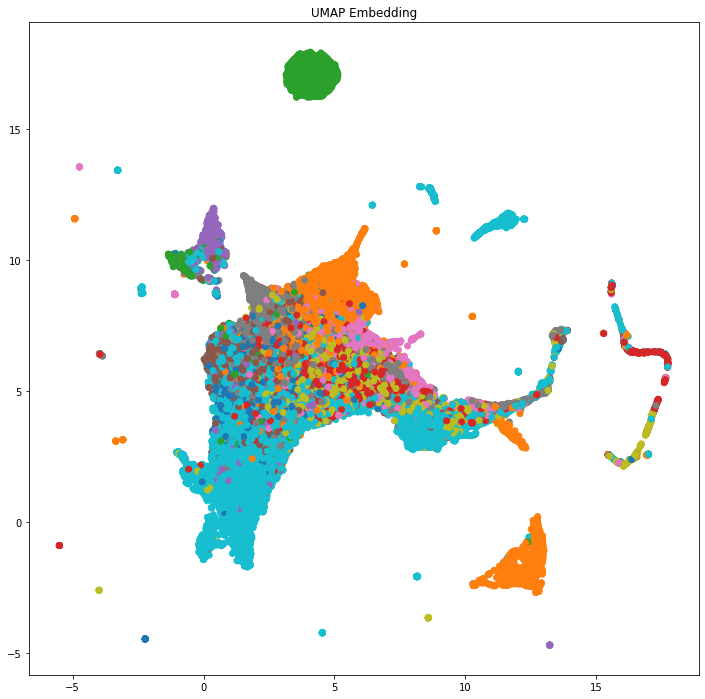

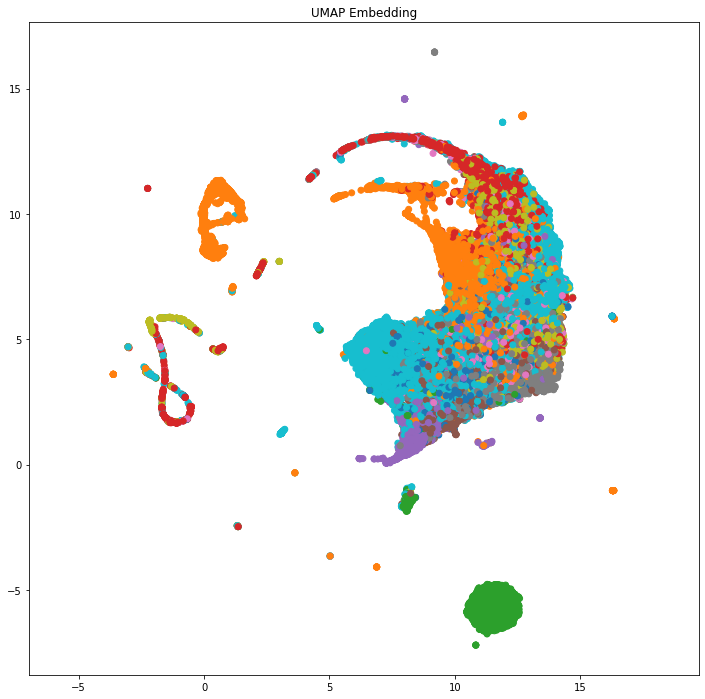

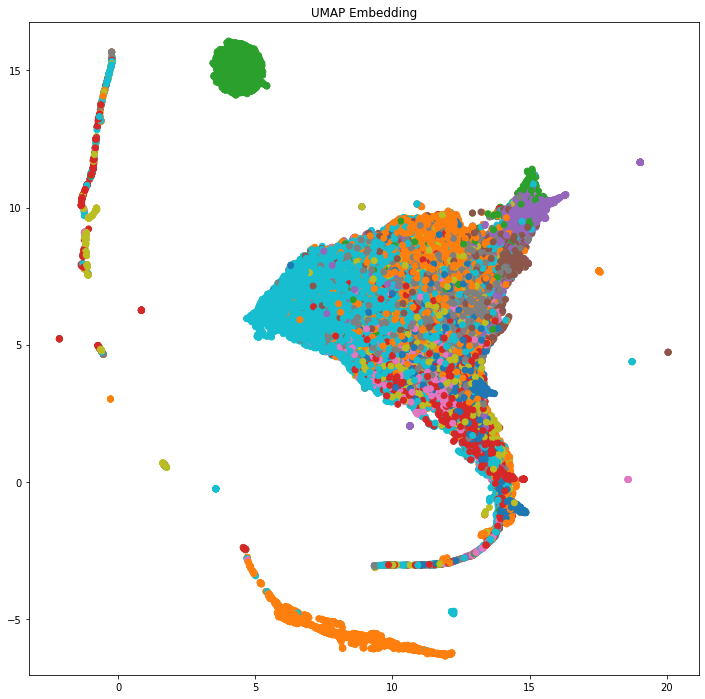

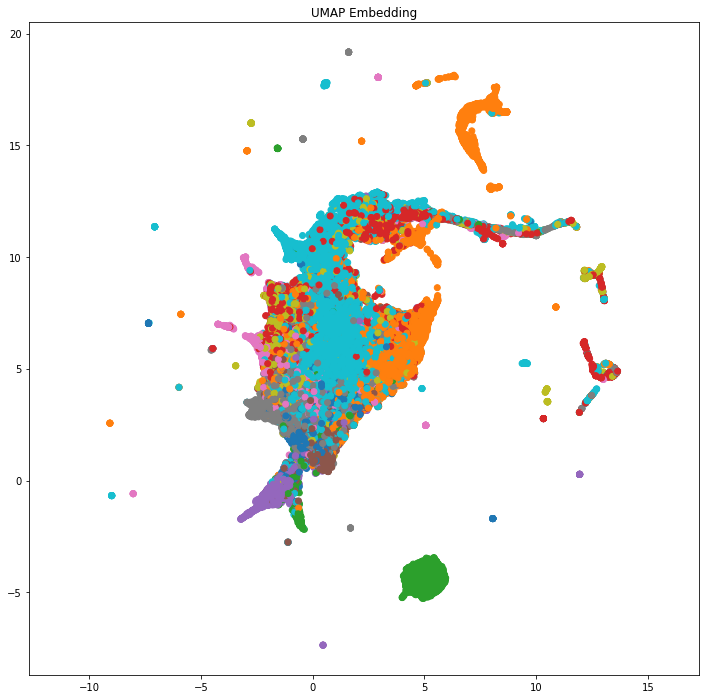

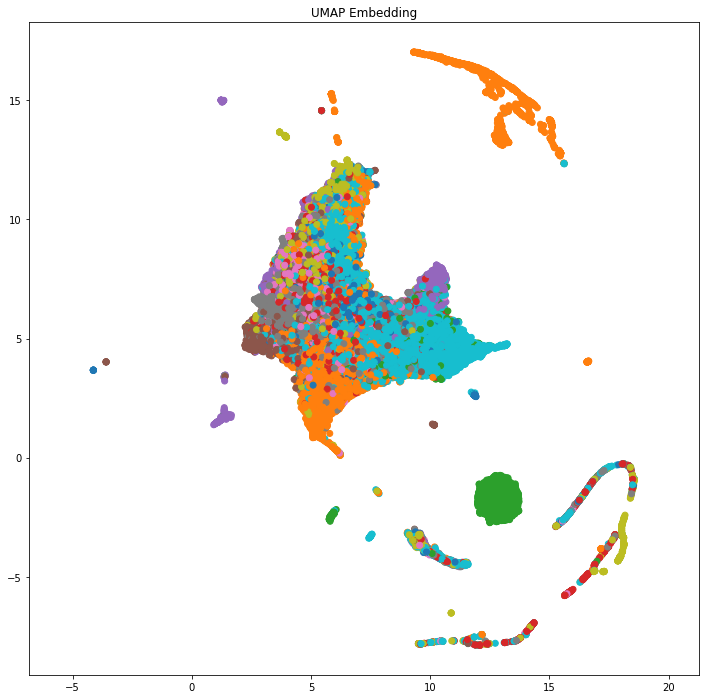

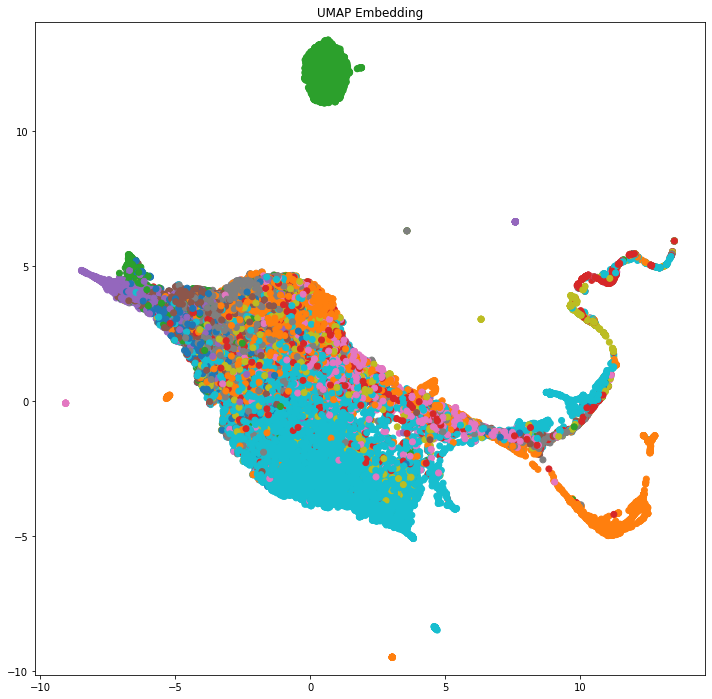

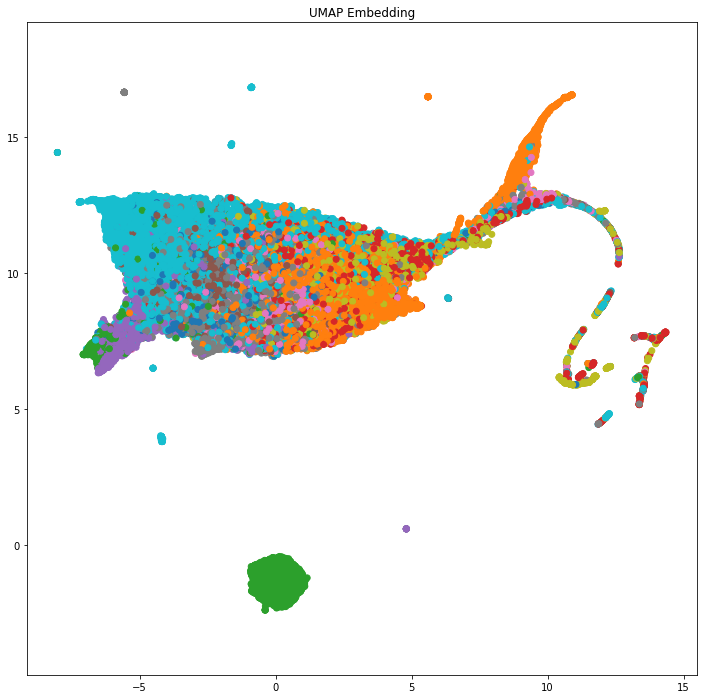

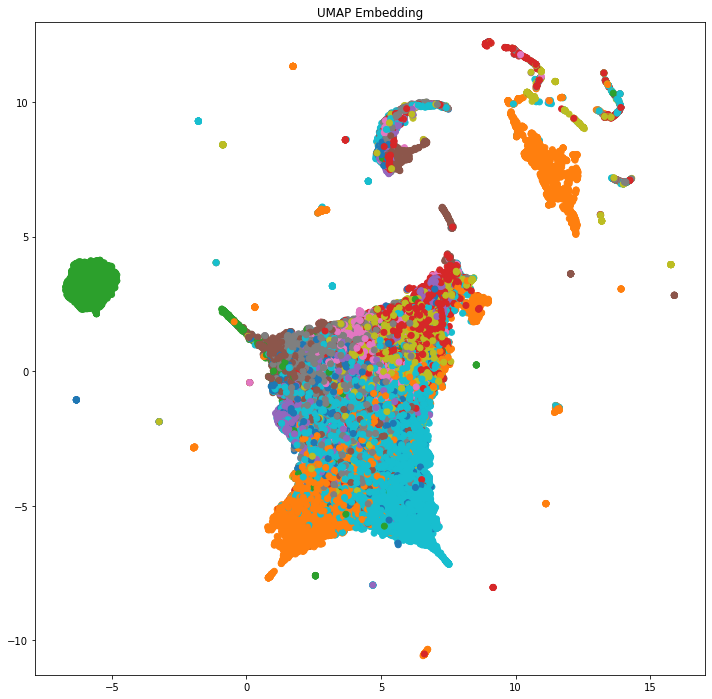

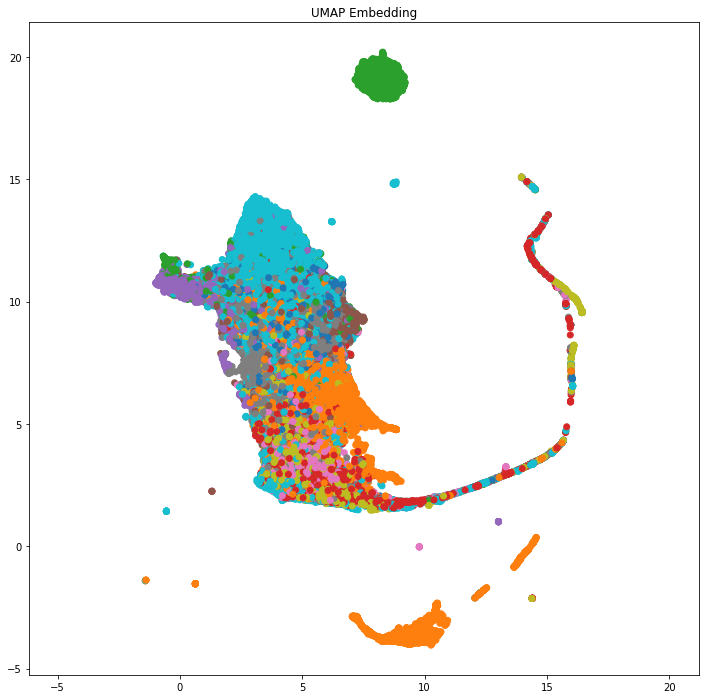

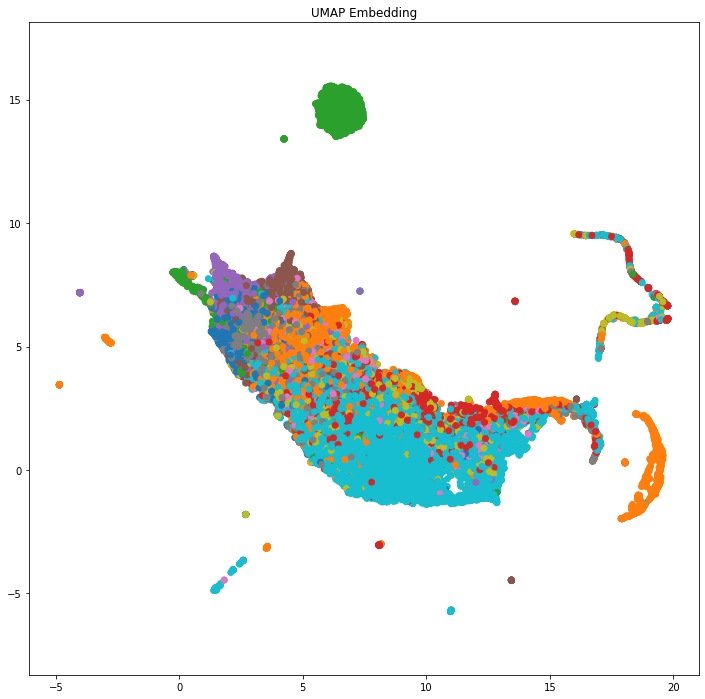

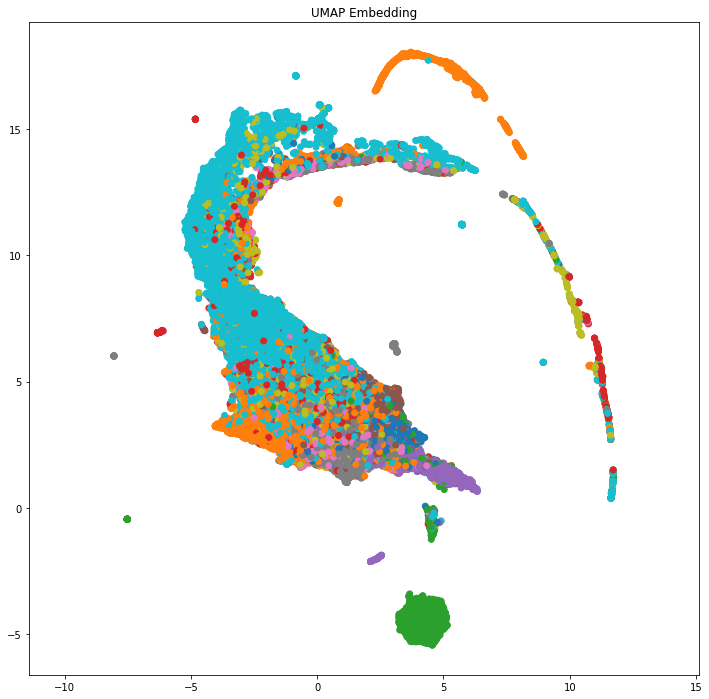

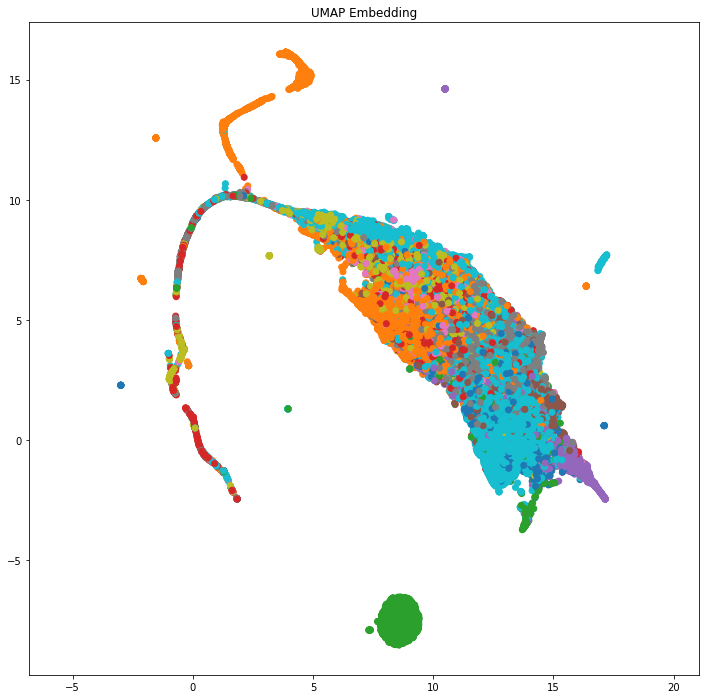

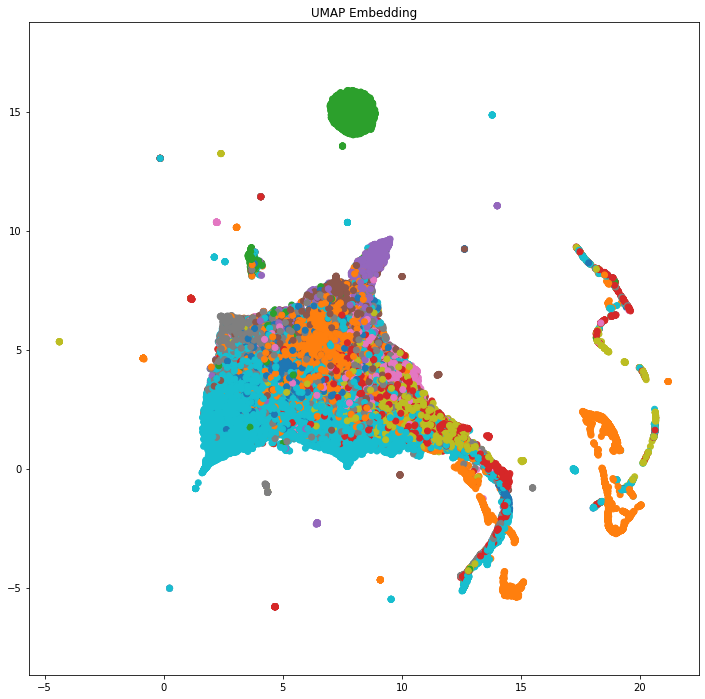

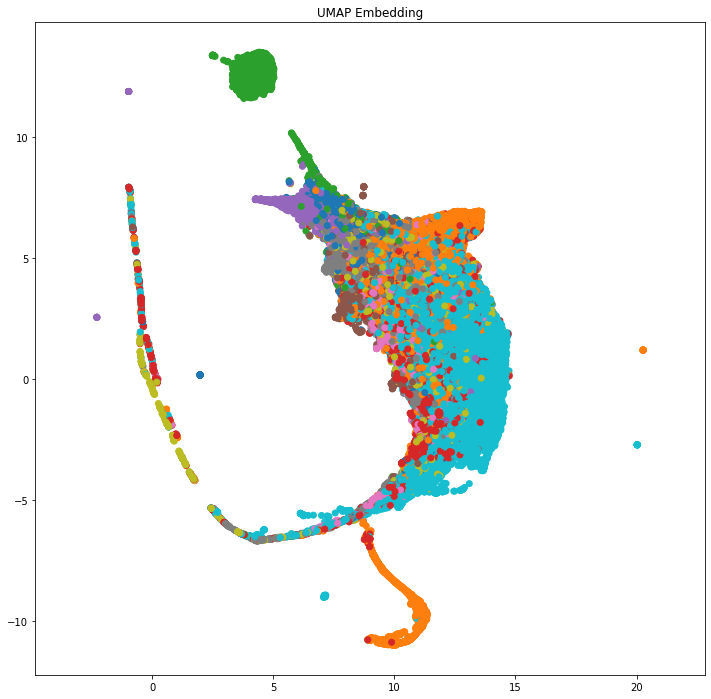

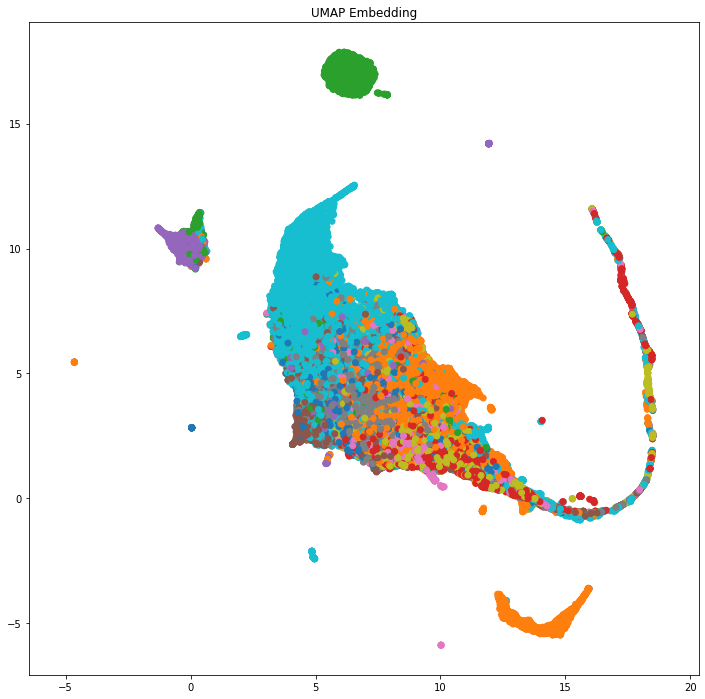

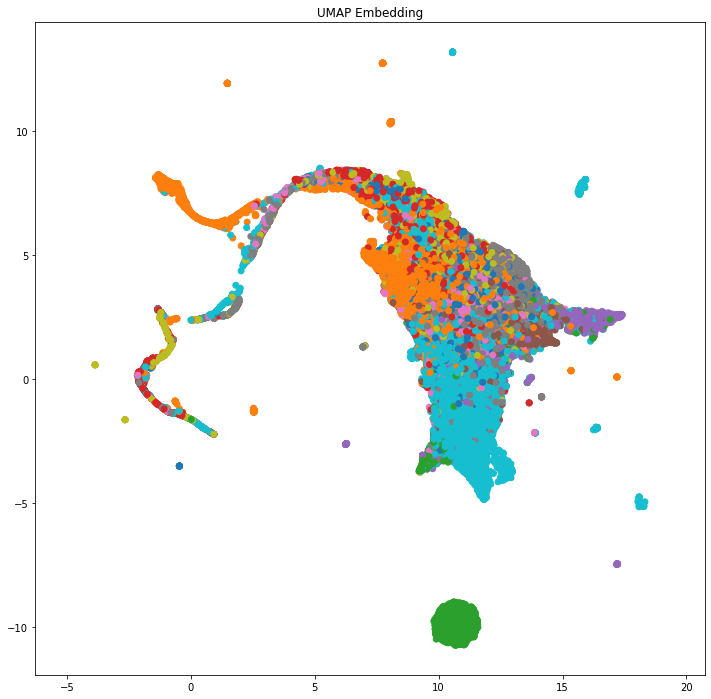

In [72]:
for j, p in enumerate(patch_emb):
    
    p_countries = dl.get_nodes(ts=dates[j])['country'].to_list()
    p_indices = [i for i in range(len(p_countries)) if p_countries[i] in most_common]
    p_labels = [most_common.index(p_countries[i]) for i in p_indices]
    p_points=p.coordinates[p_indices, :]
    umap_embedding = reducer.fit_transform(p_points)

    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    ax.scatter(
        umap_embedding[:, 0],
        umap_embedding[:, 1],
        c=[sns.color_palette()[x] for x in p_labels],
        lw=1
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP Embedding', fontsize=12)
    plt.show()
    

In [73]:
import autograd.numpy as anp
import pymanopt
import pymanopt.manifolds
import pymanopt.optimizers
import random
import local2global as l2g
import local2global.example as ex
import numpy as np

def double_intersections_nodes(patches):
    double_intersections=dict()
    for i in range(len(patches)):
        for j in range(i+1, len(patches)):
            double_intersections[(i,j)]=list(set(patches[i].nodes.tolist()).intersection(set(patches[j].nodes.tolist())))
    return double_intersections
    
def total_loss(Rotations, scales, translations, nodes,  patches,dim,  k, rand=False):
    'R: list of orthogonal matrices for embeddings of patches.'
    l=0
    fij=dict()
    
    
    for i, p in enumerate(patches):
        for j, q in enumerate(patches[i+1:]):
            if rand:
                for n in random.sample(nodes[i,j+i+1], min(k*dim+1, len(nodes[i, i+j+1]))) :
                    theta1=scales[i]*p.get_coordinate(n)@Rotations[i]+ translations[i]
                    theta2= scales[j+i+1]*q.get_coordinate(n)@Rotations[j+i+1]+translations[j+i+1]
                    l+=np.linalg.norm(theta1-theta2)**2
                
                    fij[(i, j+1+i, n)]=[theta1, theta2]
                
            else:
                for n in nodes[i,j+i+1]:
                    theta1=scales[i]*Rotations[i]@ p.get_coordinate(n)+ translations[i]
                    theta2= scales[j+i+1]*Rotations[j+i+1]@q.get_coordinate(n)+translations[j+i+1]
                    l+=np.linalg.norm(theta1-theta2)**2
                
                    fij[(i, j+1+i, n)]=[theta1, theta2]

    return 1/len(patches)*l, fij

def loss(Rotations, scales, translations, nodes,  patches, dim,k, consecutive=False, random_choice_in_intersections=False, fij=False):
    'R: list of orthogonal matrices for embeddings of patches.'

    if consecutive:
        l, f = consecutive_loss(Rotations, scales, translations  ,nodes, patches,  dim,k,  rand=random_choice_in_intersections)
        if fij:
            return l, f
        else:
            return torch.tensor(l)
    else: 
        l, f= total_loss(Rotations, scales, translations, nodes,  patches,dim,k,  rand=random_choice_in_intersections)
        if fij:
            return l, f
        else:
            return torch.tensor(l)
        
            
def consecutive_loss(Rotations, scales, translations ,nodes,  patches , dim,k, rand=True):
    'R: list of orthogonal matrices for embeddings of patches.'
    l=0
    fij=dict()
  
    
    
    for i in range(len(patches)-1):
        if rand:
            for n in random.sample(nodes[i,i+1], min(k*dim+1, len(nodes[i,i+1]))):
                theta1=scales[i]*patches[i].get_coordinate(n)@Rotations[i]+ translations[i]
                theta2= scales[i+1]*patches[i+1].get_coordinate(n)@Rotations[i+1]+translations[i+1]
                l+=np.linalg.norm(theta1-theta2)**2
                
                fij[(i, 1+i, n)]=[theta1, theta2]
        else:
            for n in nodes[i,i+1]:
                theta1=scales[i]*patches[i].get_coordinate(n)@Rotations[i]+ translations[i]
                theta2= scales[i+1]*patches[i+1].get_coordinate(n)@Rotations[i+1]+translations[i+1]
                l+=np.linalg.norm(theta1-theta2)**2
                
                fij[(i, 1+i, n)]=[theta1, theta2]
            

    return l, fij


    
def loss_aligned_emb(patches, nodes):
    l=0
    for i, p in enumerate(patches):
        for j, q in enumerate(patches[i+1:]):
            for n in nodes[i, i+j+1]:
                l+=np.linalg.norm(p.get_coordinate(n) - q.get_coordinate(n))**2
    return l




def ANPloss_nodes_consecutive_patches(Rotations, translations ,scales, patches, nodes, dim,k, rand=True):
    'R: list of orthogonal matrices for embeddings of patches.'
    l=0
    #fij=dict()
    for i in range(len(patches)-1):
        if rand:
            
            for n in random.sample(nodes[i,i+1], min(k*dim+1, len(nodes[i,i+1]))):
                theta1=scales[i]*patches[i].get_coordinate(n)@Rotations[i]+ translations[i]
                theta2= scales[i+1]*patches[i+1].get_coordinate(n)@Rotations[i+1]+translations[i+1]
                l+=anp.linalg.norm(theta1-theta2)**2
        else:
            for n in nodes[i,i+1]:
                theta1=scales[i]*patches[i].get_coordinate(n)@Rotations[i]+ translations[i]
                theta2= scales[i+1]*patches[i+1].get_coordinate(n)@Rotations[i+1]+translations[i+1]
                l+=anp.linalg.norm(theta1-theta2)**2

    return l #, fij

def ANPloss_nodes(Rotations,  translations , scales, patches, nodes, dim,k, rand=True):
    'R: list of orthogonal matrices for embeddings of patches.'
    l=0
    #fij=dict()
    #Rotations=[torch.tensor(arr).clone().detach().requires_grad_(True) for arr in Rotations]
    #scales=[torch.tensor(arr).clone().detach().requires_grad_(True) for arr in scales]
    #translations=[torch.tensor(arr).clone().detach().requires_grad_(True) for arr in translations]
    for i, p in enumerate(patches):
        for j, q in enumerate(patches[i+1:]):
            if rand:
                for n in random.sample(nodes[i,j+i+1], min(k*dim+1, len(nodes[i, j+1+i]))) :
                    theta1=scales[i]*p.get_coordinate(n)@Rotations[i]+ translations[i]
                    theta2= scales[j+i+1]*q.get_coordinate(n)@Rotations[j+i+1]+translations[j+i+1]
                    l+=anp.linalg.norm(theta1-theta2)**2
                
                    #fij[(i, j+1+i, n)]=[theta1, theta2]
                
            else:
                for n in nodes[i,j+i+1]:
                    theta1=scales[i]* p.get_coordinate(n)@Rotations[i]+ translations[i]
                    theta2= scales[j+i+1]*q.get_coordinate(n)@Rotations[j+i+1]+translations[j+i+1]
                    l+=anp.linalg.norm(theta1-theta2)**2
                
                    #fij[(i, j+1+i, n)]=[theta1, theta2]

    return 1/len(patches)*l #fij



def optimization(patches, nodes,k,consecutive=True,   random_choice=True ):
    n_patches=len(patches)
    dim= np.shape(patches[0].coordinates)[1]


    anp.random.seed(42)

    Od=[pymanopt.manifolds.SpecialOrthogonalGroup(dim) for i in range(n_patches)]
    Rd=[ pymanopt.manifolds.Euclidean(dim) for i in range(n_patches)]
    R1=[ pymanopt.manifolds.Euclidean(1) for i in range(n_patches)]
    prod=Od + Rd + R1


    manifold = pymanopt.manifolds.product.Product(prod)


    
    if consecutive:
        @pymanopt.function.autograd(manifold)
        def cost(*R):
    
            Rs=[r for r in R[:n_patches]]
            ts=[t for t in R[n_patches:2*n_patches]]
            ss=[sr for sr in R[2*n_patches :]]
            return ANPloss_nodes_consecutive_patches(Rs, ss, ts , patches, nodes, dim, k, rand=random_choice)
    else:
        @pymanopt.function.autograd(manifold)
        def cost(*R):
    
            Rs=[r for r in R[:n_patches]]
            ts=[t for t in R[n_patches:2*n_patches]]
            ss=[sr for sr in R[2*n_patches :]]
            return ANPloss_nodes(Rs, ss, ts , patches, nodes, dim, k, rand=random_choice)
        

    problem = pymanopt.Problem(manifold, cost)

    optimizer = pymanopt.optimizers.SteepestDescent()
    result = optimizer.run(problem,  reuse_line_searcher=True)

    Rotations=result.point[:n_patches]

    translations=result.point[n_patches:2*n_patches]

    scales=result.point[2*n_patches:]
    emb_problem = l2g.AlignmentProblem(patches)

    embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
    for node, patch_list in enumerate(emb_problem.patch_index):
        embedding[node] = np.mean([scales[i]*emb_problem.patches[p].get_coordinate(node)@Rotations[i] + translations[i] for i, p in enumerate(patch_list)], axis=0)
    
    
    return result, embedding



def loss_dictionary(Rs, ss, ts, nodes, patches, dim, k):
    L=dict()
    for i in range(2):
        for j in range(2):
            L[i,j]=loss(Rs, ss, ts, nodes,  patches,
                            dim, k, consecutive=i, random_choice_in_intersections=j, fij=False)
    return L

In [74]:
patches=patch_emb
nodes_int=double_intersections_nodes(patches)

In [ ]:
nodes_list=[p.nodes for p in patches]
intersection = nodes_list[0]
for l in nodes_list[1:]:
    intersection = np.intersect1d(l, intersection)

In [ ]:
[len(l) for l in list(nodes_int.values())]

In [ ]:
NODES_dict={}
for i in range(len(patches)):
    for j in range(i+1, len(patches)):
        NODES_dict[i, j]=intersection.tolist()

In [ ]:
type(nodes_int[0,1])

In [ ]:
NODES_dict[0,1]

In [112]:
from pymanopt.manifolds import Stiefel, Euclidean,SpecialOrthogonalGroup,  Product
from pymanopt.optimizers import SteepestDescent
n_patches=len(patches)
dim= np.shape(patches[0].coordinates)[1]


anp.random.seed(42)

#Od_st=Stiefel(n=dim,p=dim,   k= n_patches)
Od_sp= SpecialOrthogonalGroup(n=dim, k=n_patches)#rotations #this should be pymanopt.manifolds.stiefel.Stiefel(dim, dim) 
Rd=Euclidean(dim*(n_patches))  #shifts
R1=Euclidean(n_patches-1)  #scales



manifold = Product([Od_sp, Rd, R1] )


    
@pymanopt.function.autograd(manifold)
def cost(R,t, s):
    
    t=t.reshape(n_patches, dim) #=anp.append(np.zeros(dim), t.reshape(n_patches-1, dim)).reshape(n_patches, dim)
    s=anp.append(1,s)
    return ANPloss_nodes_consecutive_patches(R, t ,s, patches, nodes_int, dim,k=100, rand=True)



problem = pymanopt.Problem(manifold, cost)


optimizer = pymanopt.optimizers.SteepestDescent()



In [113]:
result = optimizer.run(problem,  reuse_line_searcher=True)


Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +6.6550247565971233e+05    9.04011557e+04    
   2         +5.7927757779829612e+05    8.34319287e+04    
   3         +2.9371969604195945e+05    5.55198222e+04    
   4         +5.8342972332006029e+04    2.15097243e+04    
   5         +3.4193483721297140e+04    1.85005207e+04    
   6         +1.0644608970647501e+04    4.59885560e+03    
   7         +6.8633550565382193e+03    6.68450288e+03    
   8         +3.9455114174843311e+03    2.72663832e+03    
   9         +3.2476023825027505e+03    1.87986988e+03    
  10         +2.8342678591385720e+03    2.83329959e+03    
  11         +2.3805542345415020e+03    1.94465413e+03    
  12         +2.1163516899859287e+03    1.76824427e+03    
  13         +1.8584683011579066e+03    1.00643325e+03    
  14         +1.7113061410966141e+03    1.76502312e+03    
  15         +1.4644838535795716e+03    1.

In [114]:
R=result.point[0]
tr=result.point[1].reshape(n_patches, dim)
s=anp.append(1,result.point[2])


emb_problem = l2g.AlignmentProblem(patches)
embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
for node, patch_list in enumerate(emb_problem.patch_index):
    embedding[node] = np.mean([s[i]*emb_problem.patches[p].get_coordinate(node)@R[i] + tr[i] for i, p in enumerate(patch_list)], axis=0)

In [115]:
umap_embedding = reducer.fit_transform(embedding)

In [105]:


umap_old_emb= reducer.fit_transform(old_emb)


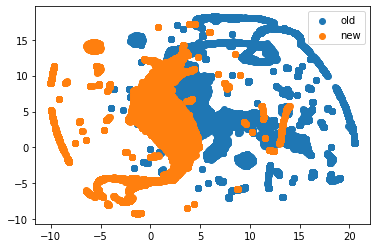

In [116]:

plt.scatter(umap_old_emb[:, 0], umap_old_emb[:,1], label='old')
plt.scatter(umap_embedding[:,0], umap_embedding[:,1], label='new')
plt.legend()
plt.show()


In [86]:
#ADDED 
#TO GET THE EMBEDDING USING STANDARD L2G
pr=l2g.AlignmentProblem(patch_emb)
old_emb=pr.get_aligned_embedding(scale=True)

Compute relative transformations:   0%|          | 0/870 [00:00<?, ?it/s]

Compute relative transformations:   0%|          | 0/870 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/30 [00:00<?, ?it/s]

In [87]:
loss_aligned_emb(pr.patches, nodes_int)

np.float64(12223753.325590987)

# Method 2

In [126]:
emb_problem.n_nodes

85428

In [130]:
max([len(p.nodes) for p in patches])    
    

84734

In [133]:
p=patches[0]
q=patches[1]
p.nodes
new_nodes= p.nodes.tolist() + q.nodes.tolist()
np.shape(embedding[new_nodes, :])

(169196, 10)

In [134]:
patches1=patches[:15]
patches2=patches[15:]
n_sub_patches=len(patches1)

def combine_patch_emb(p1, p2, coord):
    new_nodes=p1.nodes.tolist() + p2.nodes.tolist()
    
    
    return Patch(new_nodes, coord)
    

In [168]:
emb_problem = l2g.AlignmentProblem(patches)
embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
emb_list=[]
sub_patches=[patches[0], patches[1]]
sub_nodes=dict()
sub_nodes[0,1]=nodes_int[0,1]

for j in range(2, n_patches):
    


    anp.random.seed(42)

#Od_st=Stiefel(n=dim,p=dim,   k= n_patches)
    Od_sp= SpecialOrthogonalGroup(n=dim, k=2)#rotations #this should be pymanopt.manifolds.stiefel.Stiefel(dim, dim) 
    Rd=Euclidean(dim*(2))  #shifts
    R1=Euclidean(1)  #scales



    manifold = Product([Od_sp, Rd, R1] )


    
    @pymanopt.function.autograd(manifold)
    def cost(R,t, s):
    
        t=t.reshape(2, dim) #=anp.append(np.zeros(dim), t.reshape(n_patches-1, dim)).reshape(n_patches, dim)
        s=anp.append(1,s)
        return ANPloss_nodes_consecutive_patches(R, t ,s, sub_patches, sub_nodes, dim,k=100, rand=True)



    problem = pymanopt.Problem(manifold, cost)


    optimizer = pymanopt.optimizers.SteepestDescent()
    
    result = optimizer.run(problem,  reuse_line_searcher=True)
    
    rot=result.point[0]
    shifts=result.point[1].reshape(2, dim)
    scales=anp.append(1,result.point[2])
    
    sub_prob=l2g.AlignmentProblem(sub_patches)
    for node, patch_list in enumerate(sub_prob.patch_index):
        embedding[node] = np.mean([scales[i]*sub_prob.patches[p].get_coordinate(node)@rot[i] + shifts[i] 
                                   for i, p in enumerate(patch_list)], axis=0)
    
    emb_list.append(embedding)
    new_nodes=list(set(sub_patches[0].nodes.tolist() + sub_patches[1].nodes.tolist()))
    
    p_new=Patch(new_nodes, embedding[new_nodes, :] )
    sub_patches=[p_new, patches[j]]
    sub_nodes[0,1]=list(set(new_nodes).intersection(set(patches[j].nodes.tolist())))

        

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +2.4741553271857854e+04    1.37757460e+04    
   2         +1.3269020203577325e+04    9.74033051e+03    
   3         +1.0937329467531765e+04    9.23906172e+03    
   4         +3.6226360309088477e+03    5.07902173e+03    
   5         +4.6649871544901316e+02    9.05746378e+02    
   6         +4.1565015906852398e+02    8.49057365e+02    
   7         +3.3974123812586021e+02    2.10450635e+02    
   8         +3.3121975484559107e+02    3.54054611e+02    
   9         +3.1570279736199240e+02    7.64018681e+01    
  10         +3.2175795762849367e+02    2.28250530e+02    
Terminated - min step_size reached after 10 iterations, 16.89 seconds.

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +4.1903202613448571e+04    2.41208662e+04    
   2         +2

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +4.2160699761673030e+04    2.35975194e+04    
   2         +2.1572617958458821e+04    1.84377893e+04    
   3         +1.0221130126291953e+04    1.23073444e+04    
   4         +1.7694773254801644e+03    4.05495833e+03    
   5         +7.7877697168418069e+02    1.84316638e+03    
   6         +5.2574296507516067e+02    2.41045903e+03    
   7         +3.9651089018133524e+02    1.99495610e+03    
   8         +1.9018611834420267e+02    8.58724359e+02    
   9         +1.7080985092202820e+02    1.34165818e+03    
  10         +9.9032148195625695e+01    8.57164870e+02    
  11         +8.2757698308882382e+01    8.82263429e+02    
  12         +3.9895469233616325e+01    3.21583483e+02    
  13         +2.9981169579837420e+01    5.47641179e+02    
  14         +1.4457294404875368e+01    2.53987640e+02    
  15         +1.2017508535795754e+01    3.

  13         +1.7720788303081932e+01    2.40154735e+02    
Terminated - min step_size reached after 13 iterations, 22.12 seconds.

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +4.6529823258525510e+04    2.58891325e+04    
   2         +2.3682848332242800e+04    2.02588547e+04    
   3         +8.6905010839500537e+03    1.15027927e+04    
   4         +5.5081576039851880e+03    9.49755035e+03    
   5         +1.0097749982865256e+03    3.43042593e+03    
   6         +7.5637700108558022e+02    3.21280982e+03    
   7         +2.2384029278229738e+02    7.79491249e+02    
   8         +1.0590592880111124e+02    1.34931893e+03    
   9         +2.9904745548701619e+01    5.96002894e+02    
  10         +2.7471496083934486e+01    7.23233871e+02    
  11         +1.7123219089438663e+01    5.80895945e+02    
  12         +3.0325848862081539e+00    1.97781148e+02    
  13         +1.5156894181741

  11         +4.9074126409172067e+01    5.68795937e+02    
  12         +2.6169798056403948e+01    4.73444652e+02    
  13         +2.4485948449421716e+01    5.81707416e+02    
  14         +1.9424242667760772e+01    4.52448021e+02    
  15         +8.2095667957873584e+00    1.54675118e+02    
  16         +1.1684372758113780e+01    2.14555395e+02    
Terminated - min step_size reached after 16 iterations, 31.29 seconds.

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +4.3625670265787456e+04    2.49114454e+04    
   2         +2.1945489708491761e+04    1.90512435e+04    
   3         +1.1588475559645691e+04    1.34518908e+04    
   4         +6.9481486594670596e+03    1.08693483e+04    
   5         +1.9046426146125045e+03    5.20867129e+03    
   6         +1.2283796974252798e+03    4.41431592e+03    
   7         +4.5784648540325952e+02    2.17899018e+03    
   8         +2.8317206735839

In [171]:
len(emb_list)

28

In [172]:
#umap_emb_list=[reducer.fit_transform(e) for e in emb_list]
umap_last_emb=reducer.fit_transform(emb_list[-1])

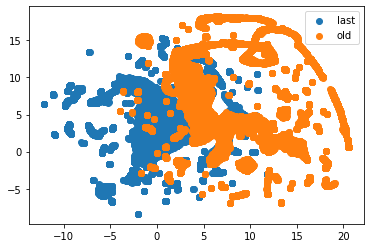

In [176]:
plt.scatter(umap_last_emb[:, 0], umap_last_emb[:,1] , label='last')
plt.scatter(umap_old_emb[:, 0], umap_old_emb[:,1], label='old')
#plt.scatter(umap_embedding[:,0], umap_embedding[:,1], label='new')
plt.legend()
plt.show()


In [156]:
len(p.nodes.tolist() + q.nodes.tolist())

169196

In [163]:
np.shape(old_emb)

(85428, 10)

In [ ]:
def reduce_data(data, date, most_common):
    countries = dl.get_nodes(ts=date)['country'].to_list()
    indices = [i for i in range(len(countries)) if countries[i] in most_common]
    points = data[indices, :]
    labels = [most_common.index(countries[i]) for i in indices]
    return points, labels

In [ ]:
def create_plot(umap_embedding, labels, p):
    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    ax.scatter(
        umap_embedding[p][:, 0],
        umap_embedding[p][:, 1],
        c=[sns.color_palette()[x] for x in labels[p]],
        lw=1
    )
    return fig

In [ ]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, metric='euclidean')

In [ ]:
embeddings = []
for i,d in enumerate(dates):
    patch = tg_graphs[d]
    embeddings.append(models[i].encode(patch).detach().numpy())

In [ ]:
def create_umap(points, reducer):
    return reducer.fit(points)

In [ ]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, metric='euclidean')
reducer.fit_transform(emb)

In [ ]:
points = []
labels = []
umaps = []
for i,d in enumerate(dates):
    p, l = reduce_data(embeddings[i], d, most_common)
    points.append(p)
    labels.append(l)
    umaps.append(create_umap(p, reducer))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    umaps[1][:, 0],
    umaps[1][:, 1],
    c=[sns.color_palette()[x] for x in labels[1]],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(8,20))
for i in range(4):
    ax[i].scatter(
        umaps[i][:, 0],
        umaps[i][:, 1],
        c=[sns.color_palette()[x] for x in labels[i]],
        lw=1
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()